# Authentication of Vincent van Gogh's Artwork

In [1]:
import tensorflow as tf

In [2]:
class Config:
    class data:
        input_shape = (300, 300, 3)
        batch_size = 64

        buffer_size = 64 * 1000

    class model:
        dropout = 0.2
        feature_layers = [
            'block1a_activation',
            'block2d_activation',
            'block3a_activation',
            'block5f_activation',
            'top_activation']

    class training:
        epochs = 100

        learning_rates = [0.0001, 0.005, 0.001, 0.0001]
        learning_rate_boundaries = [20, 50, 80]
        
        early_stopping_patience = 50
        reduce_lr_on_plateau_patience = 20
        reduce_lr_on_plateau_factor = 0.5

        logs = '/datasets/vgdb_2016/logs/vg/efficientb4'

        fine_tune_epochs = 20
        fine_tune_lr = 0.0001
        frozen_layers = 100

    seed = 24812

## Setup

In [3]:
import os

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import shutil

In [4]:
sns.set()

## Datasets

In [5]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    '/datasets/vgdb_2016/patches/random/train',
    batch_size=Config.data.batch_size,
    image_size=Config.data.input_shape[:2],
    seed=Config.seed)

valid_data = tf.keras.preprocessing.image_dataset_from_directory(
    '/datasets/vgdb_2016/patches/random/valid',
    batch_size=Config.data.batch_size,
    image_size=Config.data.input_shape[:2],
    shuffle=False)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    '/datasets/vgdb_2016/patches/random/test',
    batch_size=Config.data.batch_size,
    image_size=Config.data.input_shape[:2],
    shuffle=False)

Found 18500 files belonging to 2 classes.
Found 7900 files belonging to 2 classes.
Found 6700 files belonging to 2 classes.


In [6]:
def prepare(d):
    return d.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

train_data = prepare(train_data)
valid_data = prepare(valid_data)
test_data = prepare(test_data)

### Augmentation Policy

In [7]:
from tensorflow.keras.layers.experimental.preprocessing import (RandomFlip, RandomRotation,
                                                                RandomContrast, RandomZoom)

data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(.5),
  RandomContrast(.2),
  RandomZoom(.25)
], name='augmentation')

## Network

In [8]:
from tensorflow.keras import Model

def get_backbone(shape, feature_layers):
    ef = tf.keras.applications.EfficientNetB4(include_top=False, input_shape=shape)
    ls = [ef.get_layer(l).output for l in feature_layers]

    return Model(
        ef.inputs,
        ls,
        name='efficientnetb4_backbone'
    )

efficientnetb4 = get_backbone(Config.data.input_shape, Config.model.feature_layers)
efficientnetb4.trainable = False

In [9]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (Dropout, Dense, Concatenate,
                                     GlobalAveragePooling2D)

def build_authenticator(
    backbone,
    shape,
    global_bool=GlobalAveragePooling2D,
    dropout=.2,
    augmentation=None):
    p = global_bool(name='pool')

    y = x = Input(shape, name='images')

    if augmentation:
        y = augmentation(y)

    features = backbone(y)
    features = [p(f) for f in features]
    
    y = Concatenate(name='features_concat')(features)
    
    if dropout:
        y = Dropout(rate=dropout)(y)
    
    y = Dense(1, name='predictions')(y)

    return Model(x, y, name='vg_authenticator')


vg = build_authenticator(backbone=efficientnetb4,
                         augmentation=data_augmentation,
                         shape=Config.data.input_shape,
                         dropout=Config.model.dropout)

In [10]:
tf.keras.utils.plot_model(vg, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


## Training

### Learning Rate Behavior over Time

In [11]:
steps_per_epoch = len(train_data)

LR = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[b * steps_per_epoch for b in Config.training.learning_rate_boundaries],
    values=Config.training.learning_rates
)

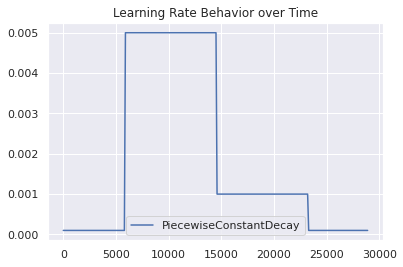

In [12]:
#@title

def plot_lr_over_time():
    steps = tf.range(0, steps_per_epoch * Config.training.epochs, 100)
    lr_over_time = tf.stack([LR(i) for i in steps])

    sns.lineplot(x=steps, y=lr_over_time, label='PiecewiseConstantDecay')
    plt.title('Learning Rate Behavior over Time');

plot_lr_over_time()

### Callbacks

In [13]:
class TensorBoardExt(tf.keras.callbacks.TensorBoard):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs.update({'lr': self.model.optimizer.lr(epoch * steps_per_epoch)})
        super().on_epoch_end(epoch, logs)

In [14]:
callbacks = [
    tf.keras.callbacks.TerminateOnNaN(),
    tf.keras.callbacks.EarlyStopping(
        patience=Config.training.early_stopping_patience,
        verbose=1),
    TensorBoardExt(
        log_dir=Config.training.logs,
        histogram_freq=10,
        write_graph=False,
        profile_batch = '8,36'),
    tf.keras.callbacks.ModelCheckpoint(
        Config.training.logs + '/weights.h5',
        save_weights_only=True,
        save_best_only=True,
        verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(
        patience=Config.training.reduce_lr_on_plateau_patience,
        factor=Config.training.reduce_lr_on_plateau_factor,
        verbose=1),
]

### Perform Training

In [15]:
vg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
           loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
           metrics=[
             tf.keras.metrics.BinaryAccuracy(threshold=0.),
           ])

In [ ]:
try:
    shutil.rmtree(Config.training.logs, ignore_errors=True)  # WARNING: this will remove all previous logs.

    vg.fit(
        train_data,
        epochs=Config.training.epochs,
        validation_data=valid_data,
        callbacks=callbacks)

except KeyboardInterrupt: print('\ninterrupted')
else: print('done')

Epoch 1/100
290/290 [==============================] - 260s 859ms/step - loss: 0.6169 - binary_accuracy: 0.6666 - val_loss: 0.4799 - val_binary_accuracy: 0.8258

Epoch 00001: val_loss improved from inf to 0.47987, saving model to /datasets/vgdb_2016/logs/vg/efficientb4/weights.h5
Epoch 2/100
290/290 [==============================] - 228s 786ms/step - loss: 0.4356 - binary_accuracy: 0.8348 - val_loss: 0.4158 - val_binary_accuracy: 0.8363

Epoch 00002: val_loss improved from 0.47987 to 0.41580, saving model to /datasets/vgdb_2016/logs/vg/efficientb4/weights.h5
Epoch 3/100
290/290 [==============================] - 229s 786ms/step - loss: 0.3578 - binary_accuracy: 0.8788 - val_loss: 0.3963 - val_binary_accuracy: 0.8394

Epoch 00003: val_loss improved from 0.41580 to 0.39627, saving model to /datasets/vgdb_2016/logs/vg/efficientb4/weights.h5
Epoch 4/100
290/290 [==============================] - 229s 786ms/step - loss: 0.3208 - binary_accuracy: 0.8898 - val_loss: 0.3835 - val_binary_accur

### Fine-tuning

In [ ]:
vg.load_weights(Config.training.logs + '/weights.h5')

In [ ]:
if Config.training.fine_tune_epochs:
    efficientnetb4.trainable = True

    for l in efficientnetb4.layers[:Config.training.frozen_layers]:
        l.trainable = False
    
    vg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=Config.training.fune_tune_lr),
           loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
           metrics=[
             tf.keras.metrics.BinaryAccuracy(threshold=0.),
           ])

In [ ]:
if Config.training.fine_tune_epochs:
    efficientnetb4.trainable = True

    for l in efficientnetb4.layers[:Config.training.frozen_layers]:
        l.trainable = False
    
    try:
        vg.fit(
            train_data,
            initial_epoch=vg.history.epoch[-1],
            epochs=Config.training.epochs + Config.fine_tune_epochs,
            validation_data=valid_data,
            callbacks=[
                tf.keras.callbacks.TerminateOnNaN(),
                tf.keras.callbacks.EarlyStopping(
                    patience=Config.training.early_stopping_patience,
                    verbose=1),
                TensorBoardExt(
                    log_dir=Config.training.logs,
                    histogram_freq=10,
                    write_graph=False,
                    profile_batch = '8,36'),
                tf.keras.callbacks.ModelCheckpoint(
                    Config.training.logs + '/weights-ft.h5',
                    save_weights_only=True,
                    save_best_only=True,
                    verbose=1),
                tf.keras.callbacks.ReduceLROnPlateau(
                    patience=Config.training.reduce_lr_on_plateau_patience,
                    factor=Config.training.reduce_lr_on_plateau_factor,
                    verbose=1),
            ])

    except KeyboardInterrupt: print('\ninterrupted')
    else: print('done')

In [ ]:
BEST = '/weights-ft.h5'

vg.load_weights(Config.training.logs + BEST)

for l in efficientnetb4.layers:
    l.trainable = True

vg.save_weights(Config.training.logs + BEST)

## Testing

In [ ]:
def paintings_from(filenames):
    paintings, patches = zip(*(os.path.splitext(os.path.basename(f))[0].split('-') for f in filenames))
    patches = list(map(int, patches))

    return painting, patches

def predict_with_labels(data):
    y, p = [], []

    steps = len(data)

    for step, (x, _y) in enumerate(data):
        _p = vg(x, training=False)

        y.append(_y), p.append(_p)
        
        if step % (steps//10) == 0:
            print(f'{step/steps:.0f}', end='')
        print('.', end='')

    return tf.concat(y, axis=0).numpy(), tf.concat(p, axis=0).numpy()

y_test, p_test = predict_with_labels(test_data)

In [ ]:
filenames, patch_ids = paintings_from(test_data.file_paths)

test_report = pd.DataFrame({
    'filenames': filenames,
    'patch_id': patch_ids,
    'y': y_test,
    'prob': p_test.ravel(),
    'prediction': (p_test.ravel() > 0.).astype('int'),
})

In [ ]:
test_report.head()

,filenames,patch_id,y,prob,prediction
0,nvg_10500055,0,0,1.529222,1
1,nvg_10500055,1,0,1.462082,1
2,nvg_10500055,10,0,3.253293,1
3,nvg_10500055,11,0,2.539852,1
4,nvg_10500055,12,0,4.107769,1


In [ ]:
from sklearn import metrics


def print_results(test_report, labels):
    print('## Patch-level Report')

    print('Acc:    ', metrics.accuracy_score(test_report.y, test_report.prediction).round(6))
    print('Cb Acc: ', metrics.balanced_accuracy_score(test_report.y,test_report.prediction).round(6))
    print('ROC AuC:', metrics.roc_auc_score(test_report.y, test_report.prob).round(6))

    cm = metrics.confusion_matrix(
        test_report.y,
        test_report.prediction)
    
    print('Confusion Matrix:')
    print(*cm, sep='\n')
    print(*(cm / cm.sum(axis=1, keepdims=True)).round(4), sep='\n', end='\n\n')

    print('Classification Report')
    print(metrics.classification_report(
        test_report.y,
        test_report.prediction,
        target_names=labels))

print_results(test_report, test_data.class_names)

## Patch-level Report
Acc:     0.918507
Cb Acc:  0.926986
ROC AuC: 0.979347
Confusion Matrix:
[3753  447]
[  99 2401]
[0.8936 0.1064]
[0.0396 0.9604]

Classification Report
              precision    recall  f1-score   support

         nvg       0.97      0.89      0.93      4200
          vg       0.84      0.96      0.90      2500

    accuracy                           0.92      6700
   macro avg       0.91      0.93      0.92      6700
weighted avg       0.93      0.92      0.92      6700



### Paintings

### Fusion Strategies

In [ ]:
def sum_fusion(labels, distances, t=0.0):
    return np.asarray([(np.sum(d, axis=-1) > t) for d in distances], dtype=int)


def mean_fusion(labels, distances, t=0.0):
    return np.asarray([(np.mean(d, axis=-1) > t) for d in distances], dtype=int)


def farthest_fusion(labels, distances, t=0.0):
    return np.asarray([d[np.argmax(np.abs(d), axis=-1)] > t for d in distances], dtype=int)


def most_frequent_fusion(labels, distances, t=0.0):
    try:
        return np.asarray([np.argmax(np.bincount(patch_labels)) for patch_labels in labels])
    except:
        raise

In [ ]:
test_paintings_report = test_report.groupby('filenames').agg(dict(
    prob=list,
    prediction=list,
    y='mean'
))

In [ ]:
test_paintings_report['prediction_sum'] = sum_fusion(test_paintings_report.prediction, test_paintings_report.prob)
test_paintings_report['prediction_far'] = farthest_fusion(test_paintings_report.prediction, test_paintings_report.prob)
test_paintings_report['prediction_fre'] = most_frequent(test_paintings_report.prediction, test_paintings_report.prob)

In [ ]:
test_paintings_report.head()

,prob,prediction,y,prediction_sum,prediction_far,prediction_fre
filenames,,,,,,
nvg_10500055,"[1.529221534729004, 1.4620819091796875, 3.2532...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,1,1,1
nvg_10582548,"[-2.834152936935425, -8.582700729370117, -9.18...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0
nvg_10658644,"[4.779599666595459, 3.3785626888275146, 4.8165...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,1,1,1
nvg_10715961,"[-0.1469217836856842, -1.5056886672973633, -0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0
nvg_12205276,"[-5.327931880950928, -6.595683574676514, -6.32...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0


In [ ]:
print_results(test_paintings_report.assign(
    prob=np.mean(test_paintings_report.prob.values.tolist(), axis=1),
    prediction=test_paintings_report.prediction_sum
), test_data.class_names)

## Patch-level Report
Acc:     0.955224
Cb Acc:  0.964286
ROC AuC: 0.993333
Confusion Matrix:
[39  3]
[ 0 25]
[0.9286 0.0714]
[0. 1.]

Classification Report
              precision    recall  f1-score   support

         nvg       1.00      0.93      0.96        42
          vg       0.89      1.00      0.94        25

    accuracy                           0.96        67
   macro avg       0.95      0.96      0.95        67
weighted avg       0.96      0.96      0.96        67



In [ ]:
print_results(test_paintings_report.assign(
    prob=np.mean(test_paintings_report.prob.values.tolist(), axis=1),
    prediction=test_paintings_report.prediction_far
), test_data.class_names)

## Patch-level Report
Acc:     0.940299
Cb Acc:  0.944286
ROC AuC: 0.993333
Confusion Matrix:
[39  3]
[ 1 24]
[0.9286 0.0714]
[0.04 0.96]

Classification Report
              precision    recall  f1-score   support

         nvg       0.97      0.93      0.95        42
          vg       0.89      0.96      0.92        25

    accuracy                           0.94        67
   macro avg       0.93      0.94      0.94        67
weighted avg       0.94      0.94      0.94        67



In [ ]:
print_results(test_paintings_report.assign(
    prob=np.mean(test_paintings_report.prob.values.tolist(), axis=1),
    prediction=test_paintings_report.prediction_fre
), test_data.class_names)

## Patch-level Report
Acc:     0.955224
Cb Acc:  0.964286
ROC AuC: 0.993333
Confusion Matrix:
[39  3]
[ 0 25]
[0.9286 0.0714]
[0. 1.]

Classification Report
              precision    recall  f1-score   support

         nvg       1.00      0.93      0.96        42
          vg       0.89      1.00      0.94        25

    accuracy                           0.96        67
   macro avg       0.95      0.96      0.95        67
weighted avg       0.96      0.96      0.96        67



In [ ]:
test_paintings_report.head()

,prob,prediction,y,prediction_sum,prediction_far,prediction_fre
filenames,,,,,,
nvg_10500055,"[1.529221534729004, 1.4620819091796875, 3.2532...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,1,1,1
nvg_10582548,"[-2.834152936935425, -8.582700729370117, -9.18...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0
nvg_10658644,"[4.779599666595459, 3.3785626888275146, 4.8165...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,1,1,1
nvg_10715961,"[-0.1469217836856842, -1.5056886672973633, -0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0
nvg_12205276,"[-5.327931880950928, -6.595683574676514, -6.32...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0


In [ ]:
misses = (test_paintings_report.prediction_sum != test_paintings_report.y)
test_paintings_report[misses]

,prob,prediction,y,prediction_sum,prediction_far,prediction_fre
filenames,,,,,,
nvg_10500055,"[1.529221534729004, 1.4620819091796875, 3.2532...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,1,1,1
nvg_10658644,"[4.779599666595459, 3.3785626888275146, 4.8165...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,1,1,1
nvg_9780042,"[0.6879106163978577, 1.2606370449066162, 3.593...","[1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, ...",0,1,1,1


In [ ]:
misses = (test_paintings_report.prediction_far != test_paintings_report.y)
test_paintings_report[misses]

,prob,prediction,y,prediction_sum,prediction_far,prediction_fre
filenames,,,,,,
nvg_10500055,"[1.529221534729004, 1.4620819091796875, 3.2532...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,1,1,1
nvg_10658644,"[4.779599666595459, 3.3785626888275146, 4.8165...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,1,1,1
nvg_9780042,"[0.6879106163978577, 1.2606370449066162, 3.593...","[1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, ...",0,1,1,1
vg_33566806,"[2.3205909729003906, -2.534024477005005, -1.74...","[1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, ...",1,1,0,1


In [ ]:
misses = (test_paintings_report.prediction_fre != test_paintings_report.y)
test_paintings_report[misses]

,prob,prediction,y,prediction_sum,prediction_far,prediction_fre
filenames,,,,,,
nvg_10500055,"[1.529221534729004, 1.4620819091796875, 3.2532...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,1,1,1
nvg_10658644,"[4.779599666595459, 3.3785626888275146, 4.8165...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,1,1,1
nvg_9780042,"[0.6879106163978577, 1.2606370449066162, 3.593...","[1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, ...",0,1,1,1
